In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [2]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df = df.sample(n=3000)
df.shape

(3000, 10)

In [4]:
data_text = df['Summary']

In [33]:
data_text.iloc[4]

"It smells great!! It's very mild though so if you have a lot of acne or scarring you may want something else."

PREPROCESSING

In [6]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [7]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [27]:
#def preProcessString(text):
    # remove all html tags
#    text = re.sub('<.*?>', ' ', str(text))
    
    # remove all special characters
#    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    # converting all text into small letters and store them as words for furthur processing
#    text_list = text.lower().#split()
    
    # removing stopwords from the text
#    english_stop_words = set(stopwords.words('english'))
    # we have used set instead of list because, set uses hashing to store the words. So lookup is O(1).
    # where as for list the look up time is O(n) (ie., make things faster in list comprehension below)
#    text_list = [word for word in text_list if word not in english_stop_words]
    
    # stemming the words (removing prefix and postfix) using Porter stemming algorithm..
#    text_list = [ps.stem(word) for word in text_list]
    
#    return ' '.join(text_list)

In [28]:
#result = data_text.apply(preProcessString)

In [1]:
#result.sample(n=20)

In [8]:
# Convert to list
data = data_text.tolist()

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[4])

['it', 'smells', 'great', 'it', 'very', 'mild', 'though', 'so', 'if', 'you', 'have', 'lot', 'of', 'acne', 'or', 'scarring', 'you', 'may', 'want', 'something', 'else']


In [23]:
print(len(data_words))

3000


CREATE BIGRAM AND TRIGRAM MODELS

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[4]]])

['it', 'smells', 'great', 'it', 'very', 'mild', 'though', 'so', 'if', 'you', 'have', 'lot', 'of', 'acne', 'or', 'scarring', 'you', 'may', 'want', 'something', 'else']


In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [13]:
# Define functions for stopwords, bigrams, trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [25]:
print(data_words_bigrams[4])

['smells', 'great', 'mild', 'though', 'lot', 'acne', 'scarring', 'may', 'want', 'something', 'else']


CREATE THE DICTIONARY AND CORPUS

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
#id2word[0]
id2word.filter_extremes(no_below=5, no_above=0.2)
print(id2word)

Dictionary(305 unique tokens: ['excellent', 'meal', 'well', 'flavor', 'noodles']...)


In [31]:
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(len(corpus))
print(corpus[:5])

3000
[[], [(0, 1)], [(1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[],
 [('excellent', 1)],
 [('meal', 1), ('well', 1)],
 [('flavor', 1), ('noodles', 1), ('tasting', 1), ('weird', 1)],
 [('else', 1), ('great', 1), ('mild', 1), ('smells', 1), ('want', 1)]]

COHERENCE SCORE

In [34]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []  
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100) #membangun model LDAnya, iterasinya bebas kita mau set berapa
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

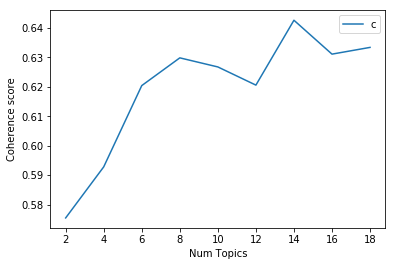

In [35]:
start=2
limit=20
step=2
model_list, coherence_values = compute_coherence_values(id2word, corpus=corpus, 
                                                        texts=texts, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5755
Num Topics = 4  has Coherence Value of 0.5928
Num Topics = 6  has Coherence Value of 0.6204
Num Topics = 8  has Coherence Value of 0.6298
Num Topics = 10  has Coherence Value of 0.6267
Num Topics = 12  has Coherence Value of 0.6206
Num Topics = 14  has Coherence Value of 0.6426
Num Topics = 16  has Coherence Value of 0.6311
Num Topics = 18  has Coherence Value of 0.6334


BUILDING TOPIC MODELING

In [37]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [38]:
from pprint import pprint

In [39]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.179*"food" + 0.141*"healthy" + 0.090*"little" + 0.064*"pretty" + '
  '0.061*"bad" + 0.053*"cat" + 0.048*"way" + 0.045*"much" + '
  '0.041*"disappointed" + 0.033*"weak"'),
 (1,
  '0.230*"like" + 0.227*"tasty" + 0.180*"excellent" + 0.069*"go" + '
  '0.064*"amazing" + 0.057*"breakfast" + 0.034*"without" + 0.029*"less" + '
  '0.019*"awful" + 0.015*"big"'),
 (2,
  '0.227*"delicious" + 0.219*"tea" + 0.193*"flavor" + 0.044*"expensive" + '
  '0.041*"wonderful" + 0.041*"dark" + 0.037*"decaf" + 0.024*"free" + '
  '0.022*"bags" + 0.021*"mild"'),
 (3,
  '0.308*"product" + 0.236*"dog" + 0.080*"cookies" + 0.038*"packaging" + '
  '0.034*"get" + 0.030*"customer" + 0.027*"pack" + 0.027*"service" + '
  '0.025*"spicy" + 0.024*"fine"'),
 (4,
  '0.379*"love" + 0.085*"favorite" + 0.077*"chocolate" + 0.072*"bars" + '
  '0.053*"vanilla" + 0.047*"kind" + 0.032*"old" + 0.030*"candy" + '
  '0.027*"protein" + 0.026*"year"'),
 (5,
  '0.224*"awesome" + 0.097*"tastes" + 0.088*"treat" + 0.064*"sugar" + '
  

In [40]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6528553652596086


VISUALISASI

In [41]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.178379  0.407035       1        1  14.170058
12     0.389634 -0.214695       2        1  11.966894
9     -0.085265 -0.037384       3        1  10.751931
7     -0.076481 -0.032432       4        1   9.511653
2      0.003050 -0.008325       5        1   8.146378
4     -0.024941 -0.015604       6        1   7.162010
3     -0.026649 -0.013570       7        1   6.904907
0     -0.061262 -0.017849       8        1   6.878449
10    -0.051319 -0.014225       9        1   5.826954
1     -0.027051 -0.007632      10        1   5.337502
6     -0.068526 -0.016999      11        1   4.835077
13    -0.041129 -0.011005      12        1   4.481473
5     -0.061806 -0.013019      13        1   3.518155
8     -0.046634 -0.004296      14        1   0.508559, topic_info=        Term       Freq       Total Category  logprob  loglift
8      great  404.00000  404.000000  Default   30.000  30.0000
22      good  278.00000  278.000000  Default   29.000  29.0000
25      love  143.00000  143.000000  Default   28.000  28.0000
18      best  167.00000  167.000000  Default   27.000  27.0000
55    coffee  155.00000  155.000000  Default   26.000  26.0000
..       ...        ...         ...      ...      ...      ...
16      fine    0.04513    9.802545  Topic14   -6.388  -0.0995
17       tea    0.04513   95.071712  Topic14   -6.388  -2.3715
18      best    0.04513  167.035783  Topic14   -6.388  -2.9351
19      ever    0.04513   42.162542  Topic14   -6.388  -1.5584
20  pretzels    0.04513    4.589678  Topic14   -6.388   0.6593

[523 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
65        8  0.878735  alternative
207       3  0.978794       always
62       10  0.946098      amazing
229       1  0.944607       amazon
224       7  0.849058      another
...     ...       ...          ...
167       4  0.936732        wrong
28        6  0.939683         year
227       3  0.752433          yet
214      11  0.956063          yum
14       12  0.982913        yummy

[259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 10, 8, 3, 5, 4, 1, 11, 2, 7, 14, 6, 9])